In [1]:
import scipy.io as read
case1 = read.loadmat('case1.mat')
case2 = read.loadmat('case2.mat')
case3 = read.loadmat('case3.mat')
case4 = read.loadmat('case4.mat')

In [2]:
#get total data
data1=case1['case1']
data2=case2['case2']
data3=case3['case3']
data4=case4['case4']

In [3]:
import numpy as np
#load all data and label data
data = []
labels = []
for i in range(int(data1.shape[3])):
    data.append(data1[:,:,:,i])
    labels.append(0)

for j in range(int(data2.shape[3])):
    data.append(data2[:,:,:,j])
    labels.append(1)
for k in range(int(data3.shape[3])):
    data.append(data3[:,:,:,k])
    labels.append(2)
for m in range(int(data4.shape[3])):
    data.append(data4[:,:,:,m])
    labels.append(3)
data = np.array(data)
labels = np.array(labels)

In [4]:
#Split data to train
data = np.array(data)
lanels = np.array(labels)
from sklearn.model_selection import train_test_split
x_train_val, x_test, y_train_val, y_test = train_test_split(data, labels, test_size=0.1,
                                                 random_state=42)
x_train_val.shape 
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1,
                                                  random_state=42)
x_train.shape


(4438, 40, 30, 1)

In [5]:
import random

def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [6]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape 
x_train_2 = pairs_train[:, 1]

In [7]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape 
x_val_2 = pairs_val[:, 1]

In [8]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape 
x_test_2 = pairs_test[:, 1]

In [10]:
import tensorflow as tf
#Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

input = tf.keras.layers.Input((40, 30, 1))
#x = tf.keras.layers.BatchNormalization()(input)
x = tf.keras.layers.Conv2D(16, (2, 2), activation="relu")(input)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Conv2D(32, (5, 5), activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.5)(x)


x = tf.keras.layers.Conv2D(64, (5, 5), activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.5)(x)



# x = tf.keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
# x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Dense(32)(x)
embedding_network = tf.keras.Model(input, x)


input_1 = tf.keras.layers.Input((40, 30, 1))
input_2 = tf.keras.layers.Input((40, 30, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = tf.keras.layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [12]:
epochs = 1000
batch_size = 64
#margin = 1  # Margin for constrastive loss.
siamese.compile(loss='binary_crossentropy', optimizer="Adam", metrics=["accuracy"])
siamese.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40, 30, 1)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 40, 30, 1)]  0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 32)           2733264     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_2[0][0]              

In [13]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/1000
139/139 [==============================] - 55s 372ms/step - loss: 0.5693 - accuracy: 0.7848 - val_loss: 0.5082 - val_accuracy: 0.8138
Epoch 2/1000
139/139 [==============================] - 50s 361ms/step - loss: 0.4556 - accuracy: 0.8880 - val_loss: 0.3658 - val_accuracy: 0.8846
Epoch 3/1000
139/139 [==============================] - 50s 358ms/step - loss: 0.3532 - accuracy: 0.9380 - val_loss: 0.2764 - val_accuracy: 0.9261
Epoch 4/1000
139/139 [==============================] - 49s 356ms/step - loss: 0.2736 - accuracy: 0.9636 - val_loss: 0.1983 - val_accuracy: 0.9585
Epoch 5/1000
139/139 [==============================] - 50s 361ms/step - loss: 0.2131 - accuracy: 0.9735 - val_loss: 0.1505 - val_accuracy: 0.9798
Epoch 6/1000
139/139 [==============================] - 50s 363ms/step - loss: 0.1675 - accuracy: 0.9829 - val_loss: 0.1355 - val_accuracy: 0.9727
Epoch 7/1000
139/139 [==============================] - 50s 363ms/step - loss: 0.1381 - accuracy: 0.9841 - val_loss: 0

139/139 [==============================] - 49s 354ms/step - loss: 0.0054 - accuracy: 0.9980 - val_loss: 0.0131 - val_accuracy: 0.9960
Epoch 57/1000
139/139 [==============================] - 49s 354ms/step - loss: 0.0066 - accuracy: 0.9976 - val_loss: 0.0150 - val_accuracy: 0.9949
Epoch 58/1000
139/139 [==============================] - 51s 365ms/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0219 - val_accuracy: 0.9939
Epoch 59/1000
139/139 [==============================] - 49s 353ms/step - loss: 0.0072 - accuracy: 0.9973 - val_loss: 0.0223 - val_accuracy: 0.9899
Epoch 60/1000
139/139 [==============================] - 49s 354ms/step - loss: 0.0063 - accuracy: 0.9979 - val_loss: 0.0158 - val_accuracy: 0.9929
Epoch 61/1000
139/139 [==============================] - 49s 355ms/step - loss: 0.0067 - accuracy: 0.9974 - val_loss: 0.0203 - val_accuracy: 0.9899
Epoch 62/1000
139/139 [==============================] - 49s 351ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 0.0268 -

139/139 [==============================] - 49s 354ms/step - loss: 0.0037 - accuracy: 0.9986 - val_loss: 0.0106 - val_accuracy: 0.9970
Epoch 112/1000
139/139 [==============================] - 49s 353ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0160 - val_accuracy: 0.9949
Epoch 113/1000
139/139 [==============================] - 51s 366ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0105 - val_accuracy: 0.9960
Epoch 114/1000
139/139 [==============================] - 48s 349ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0119 - val_accuracy: 0.9939
Epoch 115/1000
139/139 [==============================] - 49s 350ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 0.0104 - val_accuracy: 0.9949
Epoch 116/1000
139/139 [==============================] - 49s 354ms/step - loss: 0.0037 - accuracy: 0.9985 - val_loss: 0.0170 - val_accuracy: 0.9939
Epoch 117/1000
139/139 [==============================] - 50s 360ms/step - loss: 0.0030 - accuracy: 0.9986 - val_loss: 0.

139/139 [==============================] - 49s 352ms/step - loss: 0.0041 - accuracy: 0.9984 - val_loss: 0.0358 - val_accuracy: 0.9949
Epoch 167/1000
139/139 [==============================] - 49s 355ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.0253 - val_accuracy: 0.9960
Epoch 168/1000
139/139 [==============================] - 49s 355ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0114 - val_accuracy: 0.9960
Epoch 169/1000
139/139 [==============================] - 49s 354ms/step - loss: 0.0031 - accuracy: 0.9986 - val_loss: 0.0107 - val_accuracy: 0.9960
Epoch 170/1000
139/139 [==============================] - 49s 355ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.0193 - val_accuracy: 0.9919
Epoch 171/1000
139/139 [==============================] - 49s 355ms/step - loss: 0.0025 - accuracy: 0.9990 - val_loss: 0.0170 - val_accuracy: 0.9939
Epoch 172/1000
139/139 [==============================] - 50s 358ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.

139/139 [==============================] - 50s 357ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0092 - val_accuracy: 0.9980
Epoch 222/1000
139/139 [==============================] - 49s 355ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0088 - val_accuracy: 0.9990
Epoch 223/1000
139/139 [==============================] - 49s 353ms/step - loss: 8.7919e-04 - accuracy: 0.9998 - val_loss: 0.0050 - val_accuracy: 0.9990
Epoch 224/1000
139/139 [==============================] - 50s 356ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0092 - val_accuracy: 0.9990
Epoch 225/1000
139/139 [==============================] - 48s 348ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0130 - val_accuracy: 0.9990
Epoch 226/1000
139/139 [==============================] - 48s 347ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0157 - val_accuracy: 0.9980
Epoch 227/1000
139/139 [==============================] - 48s 347ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss

Epoch 276/1000
139/139 [==============================] - 34s 242ms/step - loss: 0.0014 - accuracy: 0.9994 - val_loss: 0.0068 - val_accuracy: 0.9980
Epoch 277/1000
139/139 [==============================] - 34s 244ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.0079 - val_accuracy: 0.9980
Epoch 278/1000
139/139 [==============================] - 34s 244ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0138 - val_accuracy: 0.9980
Epoch 279/1000
139/139 [==============================] - 34s 243ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.0128 - val_accuracy: 0.9980
Epoch 280/1000
139/139 [==============================] - 34s 243ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0088 - val_accuracy: 0.9990
Epoch 281/1000
139/139 [==============================] - 34s 241ms/step - loss: 0.0037 - accuracy: 0.9985 - val_loss: 0.0066 - val_accuracy: 0.9990
Epoch 282/1000
139/139 [==============================] - 33s 234ms/step - loss: 0.0019 - accuracy: 0.9991

Epoch 331/1000
139/139 [==============================] - 25s 181ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 332/1000
139/139 [==============================] - 25s 182ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0060 - val_accuracy: 0.9990
Epoch 333/1000
139/139 [==============================] - 25s 183ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0064 - val_accuracy: 0.9980
Epoch 334/1000
139/139 [==============================] - 25s 181ms/step - loss: 0.0011 - accuracy: 0.9994 - val_loss: 0.0051 - val_accuracy: 0.9980
Epoch 335/1000
139/139 [==============================] - 25s 182ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0097 - val_accuracy: 0.9970
Epoch 336/1000
139/139 [==============================] - 25s 182ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 337/1000
139/139 [==============================] - 25s 181ms/step - loss: 0.0035 - accuracy: 0.9989

139/139 [==============================] - 24s 176ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0102 - val_accuracy: 0.9949
Epoch 386/1000
139/139 [==============================] - 25s 176ms/step - loss: 7.9662e-04 - accuracy: 0.9998 - val_loss: 0.0062 - val_accuracy: 0.9970
Epoch 387/1000
139/139 [==============================] - 25s 176ms/step - loss: 8.4737e-04 - accuracy: 0.9997 - val_loss: 0.0034 - val_accuracy: 0.9980
Epoch 388/1000
139/139 [==============================] - 25s 177ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0048 - val_accuracy: 0.9990
Epoch 389/1000
139/139 [==============================] - 25s 177ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0042 - val_accuracy: 0.9990
Epoch 390/1000
139/139 [==============================] - 25s 177ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.0200 - val_accuracy: 0.9949
Epoch 391/1000
139/139 [==============================] - 24s 176ms/step - loss: 0.0017 - accuracy: 0.9993 - val_

139/139 [==============================] - 25s 177ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.0067 - val_accuracy: 0.9970
Epoch 440/1000
139/139 [==============================] - 24s 176ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0049 - val_accuracy: 0.9980
Epoch 441/1000
139/139 [==============================] - 25s 177ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0014 - val_accuracy: 0.9990
Epoch 442/1000
139/139 [==============================] - 25s 177ms/step - loss: 7.5824e-04 - accuracy: 0.9997 - val_loss: 0.0018 - val_accuracy: 0.9990
Epoch 443/1000
139/139 [==============================] - 24s 176ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0074 - val_accuracy: 0.9970
Epoch 444/1000
139/139 [==============================] - 24s 176ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 445/1000
139/139 [==============================] - 24s 175ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss

139/139 [==============================] - 24s 176ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0051 - val_accuracy: 0.9980
Epoch 494/1000
139/139 [==============================] - 24s 176ms/step - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0053 - val_accuracy: 0.9980
Epoch 495/1000
139/139 [==============================] - 24s 176ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0023 - val_accuracy: 0.9980
Epoch 496/1000
139/139 [==============================] - 24s 176ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0025 - val_accuracy: 0.9990
Epoch 497/1000
139/139 [==============================] - 24s 175ms/step - loss: 0.0015 - accuracy: 0.9991 - val_loss: 0.0031 - val_accuracy: 0.9990
Epoch 498/1000
139/139 [==============================] - 24s 176ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 499/1000
139/139 [==============================] - 24s 175ms/step - loss: 7.7308e-04 - accuracy: 0.9994 - val_loss

139/139 [==============================] - 24s 175ms/step - loss: 6.7043e-04 - accuracy: 0.9997 - val_loss: 0.0074 - val_accuracy: 0.9980
Epoch 548/1000
139/139 [==============================] - 24s 176ms/step - loss: 6.1579e-04 - accuracy: 0.9998 - val_loss: 0.0037 - val_accuracy: 0.9980
Epoch 549/1000
139/139 [==============================] - 24s 176ms/step - loss: 0.0014 - accuracy: 0.9992 - val_loss: 0.0046 - val_accuracy: 0.9970
Epoch 550/1000
139/139 [==============================] - 24s 175ms/step - loss: 2.9115e-04 - accuracy: 0.9999 - val_loss: 0.0052 - val_accuracy: 0.9980
Epoch 551/1000
139/139 [==============================] - 25s 176ms/step - loss: 4.1550e-04 - accuracy: 0.9999 - val_loss: 0.0066 - val_accuracy: 0.9970
Epoch 552/1000
139/139 [==============================] - 25s 177ms/step - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.0086 - val_accuracy: 0.9949
Epoch 553/1000
139/139 [==============================] - 24s 176ms/step - loss: 0.0013 - accuracy: 0.999

139/139 [==============================] - 24s 176ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0020 - val_accuracy: 0.9990
Epoch 602/1000
139/139 [==============================] - 25s 176ms/step - loss: 3.5227e-04 - accuracy: 0.9999 - val_loss: 6.3100e-04 - val_accuracy: 1.0000
Epoch 603/1000
139/139 [==============================] - 24s 176ms/step - loss: 3.1869e-04 - accuracy: 1.0000 - val_loss: 7.0125e-04 - val_accuracy: 1.0000
Epoch 604/1000
139/139 [==============================] - 25s 176ms/step - loss: 9.3492e-04 - accuracy: 0.9997 - val_loss: 0.0031 - val_accuracy: 0.9980
Epoch 605/1000
139/139 [==============================] - 25s 177ms/step - loss: 3.5739e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9980
Epoch 606/1000
139/139 [==============================] - 25s 177ms/step - loss: 9.2581e-04 - accuracy: 0.9995 - val_loss: 0.0033 - val_accuracy: 0.9990
Epoch 607/1000
139/139 [==============================] - 24s 176ms/step - loss: 0.0023 - acc

139/139 [==============================] - 24s 175ms/step - loss: 0.0012 - accuracy: 0.9994 - val_loss: 0.0095 - val_accuracy: 0.9980
Epoch 656/1000
139/139 [==============================] - 24s 175ms/step - loss: 4.7196e-04 - accuracy: 0.9999 - val_loss: 0.0045 - val_accuracy: 0.9990
Epoch 657/1000
139/139 [==============================] - 24s 174ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.0157 - val_accuracy: 0.9970
Epoch 658/1000
139/139 [==============================] - 24s 175ms/step - loss: 0.0011 - accuracy: 0.9995 - val_loss: 0.0111 - val_accuracy: 0.9960
Epoch 659/1000
139/139 [==============================] - 24s 174ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0086 - val_accuracy: 0.9970
Epoch 660/1000
139/139 [==============================] - 24s 174ms/step - loss: 4.9898e-04 - accuracy: 0.9999 - val_loss: 0.0043 - val_accuracy: 0.9980
Epoch 661/1000
139/139 [==============================] - 24s 174ms/step - loss: 4.1679e-04 - accuracy: 0.9999 - 

139/139 [==============================] - 24s 172ms/step - loss: 2.0594e-04 - accuracy: 1.0000 - val_loss: 4.9194e-04 - val_accuracy: 1.0000
Epoch 710/1000
139/139 [==============================] - 24s 173ms/step - loss: 8.3244e-04 - accuracy: 0.9997 - val_loss: 0.0018 - val_accuracy: 0.9990
Epoch 711/1000
139/139 [==============================] - 24s 173ms/step - loss: 6.7849e-04 - accuracy: 0.9999 - val_loss: 9.3432e-04 - val_accuracy: 1.0000
Epoch 712/1000
139/139 [==============================] - 24s 173ms/step - loss: 7.4147e-04 - accuracy: 0.9997 - val_loss: 0.0050 - val_accuracy: 0.9980
Epoch 713/1000
139/139 [==============================] - 24s 173ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0029 - val_accuracy: 0.9990
Epoch 714/1000
139/139 [==============================] - 24s 173ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 0.0061 - val_accuracy: 0.9970
Epoch 715/1000
139/139 [==============================] - 24s 173ms/step - loss: 0.0010 - accurac

Epoch 763/1000
139/139 [==============================] - 24s 173ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0068 - val_accuracy: 0.9980
Epoch 764/1000
139/139 [==============================] - 24s 173ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 765/1000
139/139 [==============================] - 24s 173ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0032 - val_accuracy: 0.9990
Epoch 766/1000
139/139 [==============================] - 24s 173ms/step - loss: 0.0016 - accuracy: 0.9992 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 767/1000
139/139 [==============================] - 24s 173ms/step - loss: 4.2970e-04 - accuracy: 1.0000 - val_loss: 7.0101e-04 - val_accuracy: 1.0000
Epoch 768/1000
139/139 [==============================] - 24s 173ms/step - loss: 2.8488e-04 - accuracy: 0.9999 - val_loss: 7.2109e-04 - val_accuracy: 1.0000
Epoch 769/1000
139/139 [==============================] - 24s 173ms/step - loss: 2.4245e-0

Epoch 817/1000
139/139 [==============================] - 24s 174ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0044 - val_accuracy: 0.9980
Epoch 818/1000
139/139 [==============================] - 24s 174ms/step - loss: 8.9460e-04 - accuracy: 0.9997 - val_loss: 0.0017 - val_accuracy: 0.9990
Epoch 819/1000
139/139 [==============================] - 24s 174ms/step - loss: 0.0011 - accuracy: 0.9995 - val_loss: 8.6707e-04 - val_accuracy: 1.0000
Epoch 820/1000
139/139 [==============================] - 24s 174ms/step - loss: 2.2196e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9990
Epoch 821/1000
139/139 [==============================] - 24s 174ms/step - loss: 1.7477e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9990
Epoch 822/1000
139/139 [==============================] - 24s 174ms/step - loss: 7.2891e-04 - accuracy: 0.9997 - val_loss: 0.0045 - val_accuracy: 0.9980
Epoch 823/1000
139/139 [==============================] - 24s 174ms/step - loss: 7.570

Epoch 871/1000
139/139 [==============================] - 24s 174ms/step - loss: 1.5764e-04 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9980
Epoch 872/1000
139/139 [==============================] - 24s 174ms/step - loss: 2.8579e-04 - accuracy: 0.9999 - val_loss: 0.0019 - val_accuracy: 0.9990
Epoch 873/1000
139/139 [==============================] - 24s 174ms/step - loss: 3.3754e-04 - accuracy: 0.9999 - val_loss: 0.0071 - val_accuracy: 0.9980
Epoch 874/1000
139/139 [==============================] - 24s 174ms/step - loss: 2.8382e-04 - accuracy: 0.9999 - val_loss: 0.0081 - val_accuracy: 0.9980
Epoch 875/1000
139/139 [==============================] - 24s 174ms/step - loss: 6.5351e-04 - accuracy: 0.9998 - val_loss: 0.0054 - val_accuracy: 0.9980
Epoch 876/1000
139/139 [==============================] - 24s 175ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0052 - val_accuracy: 0.9980
Epoch 877/1000
139/139 [==============================] - 24s 174ms/step - loss: 6.240

Epoch 925/1000
139/139 [==============================] - 25s 177ms/step - loss: 9.0033e-04 - accuracy: 0.9997 - val_loss: 0.0194 - val_accuracy: 0.9960
Epoch 926/1000
139/139 [==============================] - 25s 176ms/step - loss: 0.0010 - accuracy: 0.9995 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 927/1000
139/139 [==============================] - 25s 178ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0023 - val_accuracy: 0.9990
Epoch 928/1000
139/139 [==============================] - 25s 179ms/step - loss: 5.3768e-04 - accuracy: 0.9999 - val_loss: 0.0026 - val_accuracy: 0.9990
Epoch 929/1000
139/139 [==============================] - 25s 177ms/step - loss: 3.8536e-04 - accuracy: 0.9999 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 930/1000
139/139 [==============================] - 25s 178ms/step - loss: 8.2592e-04 - accuracy: 0.9997 - val_loss: 0.0035 - val_accuracy: 0.9980
Epoch 931/1000
139/139 [==============================] - 25s 178ms/step - loss: 2.8910e-0

139/139 [==============================] - 25s 183ms/step - loss: 7.0267e-04 - accuracy: 0.9997 - val_loss: 0.0026 - val_accuracy: 0.9980
Epoch 979/1000
139/139 [==============================] - 25s 182ms/step - loss: 4.6434e-04 - accuracy: 0.9998 - val_loss: 0.0031 - val_accuracy: 0.9990
Epoch 980/1000
139/139 [==============================] - 25s 183ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0052 - val_accuracy: 0.9990
Epoch 981/1000
139/139 [==============================] - 26s 184ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0043 - val_accuracy: 0.9980
Epoch 982/1000
139/139 [==============================] - 26s 184ms/step - loss: 6.2201e-04 - accuracy: 0.9998 - val_loss: 0.0021 - val_accuracy: 0.9990
Epoch 983/1000
139/139 [==============================] - 26s 184ms/step - loss: 1.9153e-04 - accuracy: 0.9999 - val_loss: 0.0034 - val_accuracy: 0.9990
Epoch 984/1000
139/139 [==============================] - 25s 181ms/step - loss: 0.0013 - accuracy: 0.999

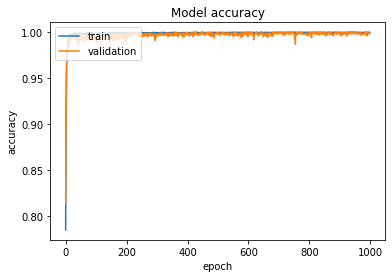

In [16]:
from matplotlib import pyplot as plt

def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")


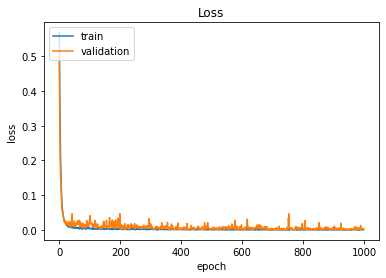

In [17]:
from matplotlib import pyplot as plt

def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="loss", title="Loss")
